In [62]:
from src.utils.evaluation_utils import compute_f1, compute_exact
from gensim.utils import deaccent

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

In [64]:
import pandas as pd
import numpy as np

In [65]:
from pathlib import Path

In [66]:
current_working_directory = Path.cwd().parent

In [67]:
results_path = current_working_directory.joinpath("results")

In [68]:
validation_results_path = results_path.joinpath("four-paragraph-train-fquad+piaf_valid.csv")
test_results_path = results_path.joinpath("four-paragraph-train-fquad+piaf_test_piaf-additional-with-from-wikipedia-bm25.csv")

In [163]:
data = pd.read_csv(test_results_path).dropna()

In [164]:
data["f1"] = np.vectorize(compute_f1)(data.prediction, data.goldlabel)
data["exact"] = np.vectorize(compute_exact)(data.prediction, data.goldlabel)

In [165]:
data.head()

,prediction,goldlabel,questions,passages_len,f1,exact
0,une limite,une limite,question: Qu’est ce que le pomérium d’après An...,1,1.0,1
1,un ingenieur autrichien,un ingénieur autrichien,question: Qui est Anselm Franz </s>,1,1.0,1
2,la bataille de Kurukshetra,bataille de Kurukshetra,question: A quoi mène les revendications au tr...,4,1.0,1
3,la route des Moluques,sud du continent américain,question: quel chemin maritime a emprunté Mage...,4,0.0,0
4,le Conseil constitutionnel,Conseil constitutionnel,question: qui peut censurer une loi ? </s>,4,1.0,1


In [167]:
(data.f1.mean()*100).round(2)

57.79

In [122]:
data.loc[data.f1 ==0]

,prediction,goldlabel,questions,passages_len,f1,exact
19,Congrès américain,Ulysses Grant,question: Quel personnalité officialisa la pro...,4,0.0,0
65,chevaux de trait légers,mareyeur Boulonnais,question: Quelle race autre que le cob est fav...,4,0.0,0
76,reproduction des esclaves,d’acheter un esclave,question: Qu'est ce qui est plus rentable que ...,4,0.0,0
81,anxiété et la dépression,Sont observés également une tendance à l'auto,question: Quels sont les autres problèmes émot...,4,0.0,0
82,une iconographie très riche,viennent puiser l’inspiration,question: Que cherche les poètes dans Pégase ?...,4,0.0,0
...,...,...,...,...,...,...
3171,Du fait de ces limitations,Peu diplomates et peu persuas,question: Pourquoi les Asperger éprouvent des ...,4,0.0,0
3173,la plus complète définition qu'ait jamais donn...,mal social dans son ensemble,question: Que décrit le discours de Dickens d'...,4,0.0,0
3180,cette méthode se révélant a priori non-viable,vaccination,question: Quelle méthode propose l'APHIS pour ...,4,0.0,0
3183,K.DINGIR,Shar-kali-sharri,question: Quel est le nom du roi de l'empire d...,4,0.0,0


In [123]:
data.questions = data.questions.str.replace("question:", "").str.replace("</s>", "")

In [124]:
import re

In [125]:
def get_question_type(question):
    """
    Process the question and get the type from it 
    """
    question = deaccent(question)
    question = question.lower()
    question = re.sub(r'\b(en|sur|de|a|par)\b', '', question)
    question = re.sub(r'\b(quels|quelle|quelles)\b', 'quel', question)
    question = question.strip()
    question_type = question.split(" ")[0]
    return question_type

In [126]:
get_question_type("de qui vient cette voiture")

'qui'

In [127]:
get_question_type("comment tu t'appele")

'comment'

In [128]:
data["question_type"] = data.questions.apply(get_question_type)
data["number_words"] = data.goldlabel.str.split(" ").apply(lambda x: len(x))
data["answer_length"] = data.goldlabel.str.len()

In [129]:
question_prepositions = ["combien","quand", "qui", "quel", "que", "pourquoi", "comment"]

In [130]:
data["question_type"].value_counts().loc[question_prepositions].sort_values(ascending=False)

quel        1029
qui          444
que          251
quand        201
combien      171
comment      168
pourquoi      63
Name: question_type, dtype: int64

In [131]:
question_type_count = data["question_type"].value_counts()

In [132]:
question_type_count.loc[question_type_count.values >=10].to_dict().keys()

dict_keys(['quel', 'qui', 'que', 'quand', 'combien', 'comment', 'quoi', 'ou', 'dans', "qu'est-ce", 'pourquoi', "qu'est", 'pour', 'avec', 'selon', "d'ou", 'partir', 'depuis', 'lors'])

In [133]:
data['question_type'] = np.where(data['question_type'].isin(question_type_count.loc[question_type_count.values >=10].to_dict().keys()), data['question_type'], 'Other')

In [134]:
data_group_question = data.groupby('question_type').agg({'f1': 'mean', 'exact': 'mean', "prediction": "count", "answer_length": "mean", "number_words": "mean"}).rename({"prediction": "count"}, axis=1)

In [138]:
data_group_question = data_group_question.loc[data_group_question["count"] >=60]\
.sort_values(by=['f1', 'answer_length'], ascending=False)

In [139]:
data_group_question = data_group_question.reset_index()

In [140]:
data_group_question

,index,question_type,f1,exact,count,answer_length,number_words
0,0,qui,0.850829,0.756757,444,15.979730,2.484234
1,1,quand,0.838506,0.681592,201,12.726368,2.691542
2,2,combien,0.802581,0.643275,171,9.929825,2.064327
3,3,ou,0.749424,0.503704,135,19.807407,3.451852
4,4,comment,0.747463,0.547619,168,21.922619,3.547619
5,5,Other,0.742692,0.539773,176,24.909091,4.153409
6,6,quel,0.740658,0.573372,1029,19.840622,3.265306
7,7,dans,0.736208,0.479675,123,20.292683,3.390244
8,8,qu'est-ce,0.724847,0.568182,88,30.227273,4.965909
9,9,que,0.712482,0.529880,251,32.286853,5.310757


In [141]:
data_group_question = data_group_question.rename({"f1": "f1-score", "exact": "Exact Match"}, axis="columns")

In [142]:
data_question_group_melt = data_group_question.melt(id_vars="question_type", value_vars=["f1-score", "Exact Match"])

In [143]:
data_question_group_melt.value = data_question_group_melt.value * 100

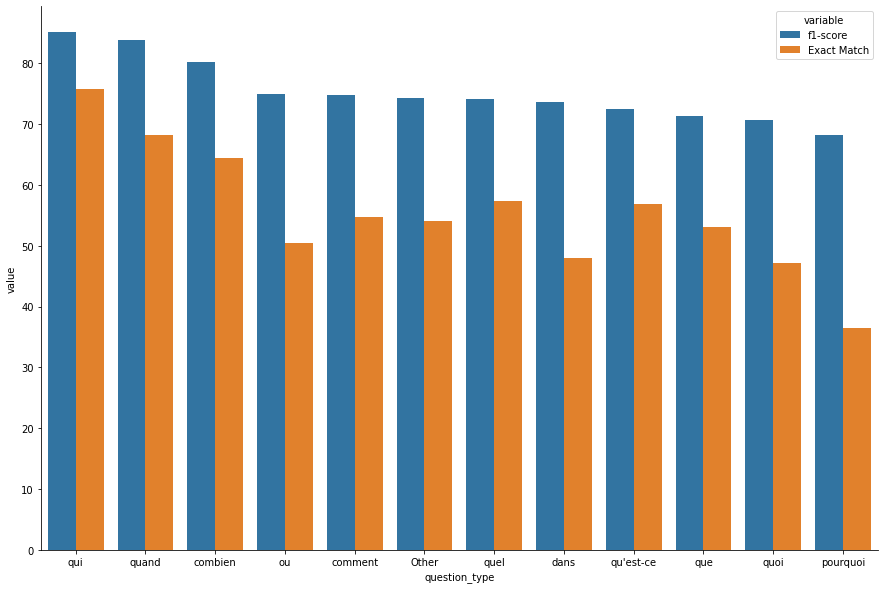

In [144]:
fig, ax1 = plt.subplots(figsize=(15, 10))
sns.barplot(x='question_type', y='value', hue='variable', data=data_question_group_melt, ax=ax1)
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
sns.despine(fig)

In [ ]:
print(data_group_question.to_latex(float_format="{:0.2f}".format))

In [ ]:
data.head()

In [ ]:
data_group_by_answer_length = data.groupby("number_words")\
.agg({"f1": 'mean', "exact": "mean", "goldlabel": "count"})\
.query("goldlabel > 1").reset_index()

In [ ]:
data_group_by_answer_length

In [ ]:
data_group_by_answer_length.plot(x="number_words", y=["f1", "exact"])
plt.show()

In [ ]:
data.loc[data.question_type == "que"]

In [ ]:
data.groupby('number_words')\
        .agg({'f1': 'mean', 
              'exact': 'mean', 
              "prediction": "count"}).rename({"prediction": "count"}, axis=1)

In [ ]:
data.head()

In [ ]:
data.loc[data.f1 == 0].to_csv(results_path.joinpath("four-paragraph-incorect-results-validation.csv"))

### Experiments analysis

In [ ]:
experiments = pd.read_csv(current_working_directory.joinpath("experiments-results.csv"),
                          usecols=["f1_score", "exact_matches", "Name", "Start Time"])

In [ ]:
experiments = experiments.sort_values("Start Time", ascending=False).dropna(subset=["Name", "exact_matches"])

In [ ]:
import re

In [ ]:
experiments

In [ ]:
good_experiments = experiments[experiments.Name.str.lower().str.contains("paragraph-train-fquad")]

In [ ]:
good_experiments["number_context"] = good_experiments.Name.str.split("-", expand=True)[0]

In [ ]:
good_experiments.Name.str.split("_", expand=True)[1].fillna("train")

In [ ]:
good_experiments["subset"] = good_experiments.Name.str.split("_", expand=True)[1].fillna("val")

In [ ]:
good_experiments.f1_score = good_experiments.f1_score.round(2)
good_experiments.exact_matches = good_experiments.exact_matches.round(2)

In [ ]:
good_experiments.sort_values(by='f1_score', ascending=False)

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x="number_context", hue="subset", y="exact_matches", data=good_experiments)
plt.show()

In [ ]:
good_experiments_table = good_experiments.pivot(index='number_context', columns='subset', values=['f1_score', 'exact_matches'])

In [ ]:
print(good_experiments_table.to_latex())

In [ ]:
good_experiments_table.columns

In [ ]:
dataset_length = {"fquad" : {"train": 20731, "validation": 3188, "test": 2189 },
                   "piaf": {"base": 3835, "additional_without_answers": 11812}}

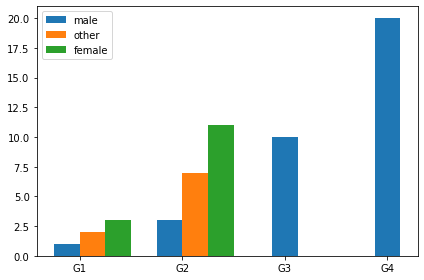

In [36]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

labels = ['G1', 'G2', 'G3', 'G4']
labels2 = ['F1', 'F2'] 
male = [1, 3, 10, 20]
female = [2, 7]
female_2 = [3, 11]

x_male = np.arange(len(male))
x_female = np.arange(len(female))

offset_male = np.zeros(len(male))
offset_female = np.zeros(len(female))

shorter = min(len(x_male), len(x_female))

width = 0.25  # the width of the bars

offset_male[:shorter] = width/2
offset_female[:shorter] = width/2

fig, ax = plt.subplots()
rects1 = ax.bar(x_male - offset_male, male, width, label='male')
rects2 = ax.bar(x_female + offset_female, female, width, label='other')
rects3 = ax.bar(x_female + 3 * offset_female, female_2, width, label='female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x_male)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

In [27]:
ourdataset_size = [20731 + 385, 3188, 5565]
squad_dataset = [50000, 50000*10/100, 50000 * 10/100]
split = ["train", "validation", "test"]

data = pd.DataFrame([ourdataset_size, squad_dataset])
data = data.T
data.columns = ["Our Dataset", "Squad Open"]
data.index = split
data.index.name = "Dataset"
data

,Our Dataset,Squad Open
Dataset,,
train,21116.0,50000.0
validation,3188.0,5000.0
test,5565.0,5000.0


In [28]:
data = data.T.reset_index().melt(id_vars="index")

In [29]:
data = data.rename({"index": "Datasets", "Dataset": "split", "value": "number of questions"}, axis="columns")

In [30]:
data

,Datasets,split,number of questions
0,Our Dataset,train,21116.0
1,Squad Open,train,50000.0
2,Our Dataset,validation,3188.0
3,Squad Open,validation,5000.0
4,Our Dataset,test,5565.0
5,Squad Open,test,5000.0


In [33]:
from numerize import numerize

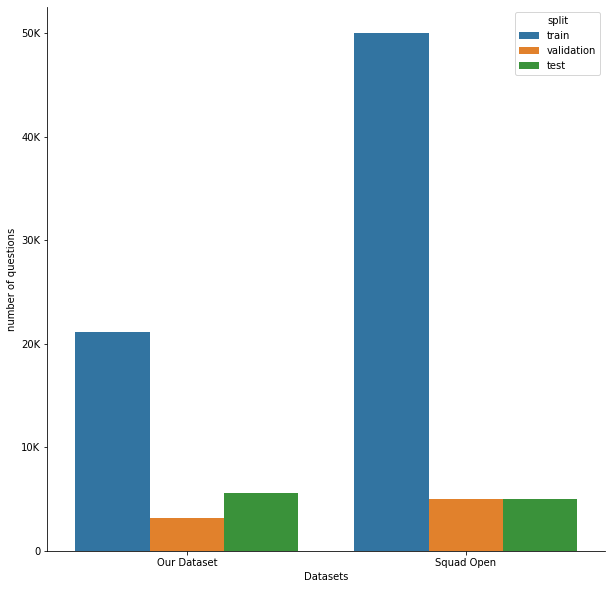

In [37]:
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.barplot(x='Datasets', y='number of questions', hue='split', data=data, ax=ax1)
ax1.yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: numerize.numerize(x)))
sns.despine(fig)

In [ ]:
ourdataset_size = [20731 + 385, 3188, 5565]
squad_dataset = [50000, 50000*10/100, 50000 * 10/100]
split = ["train", "validation", "test"]

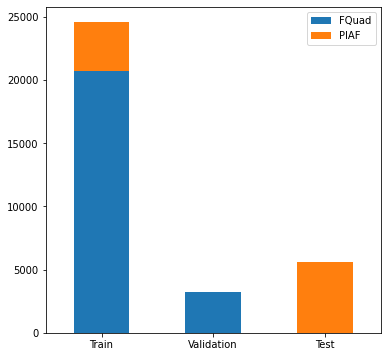

In [158]:
fquad = [20731, 3188, 0]
piaf = [3835, 0, 5565]


df = pd.DataFrame({'FQuad' : fquad, 'PIAF' : piaf}, index=["Train", "Validation", "Test"])
ax = df.plot.bar(stacked=True);

ax.figure.set_size_inches(6,6)

ax.legend(loc='upper right')
ax.tick_params(axis='x', labelrotation=0)

In [148]:
df

,a,b,c
0,3,3,3
1,5,4,5
2,4,5,4
3,2,2,6
4,1,1,1


Positive

{
    "question": "Qui est la voix française régulière de Harrison Ford ?",
    "answer": "Richard Darbois",
    "contexts": [
        {
            "title": "harrison-ford",
            "content": "En version française, Richard Darbois est la voix régulière d'Harrison Ford depuis Blade Runner en 1982. Il l'a ensuite doublé notamment dans Indiana Jones et la Dernière Croisade et sa suite, Le Fugitif, Présumé Innocent, Ennemis rapprochés ainsi que dans Le Réveil de la Force (le premier film de la troisième trilogie de Star Wars,). Auparavant, Francis Lax, a été la première voix la plus fréquente d'Harrison Ford dans quelques-uns de ses premiers grands rôles (notamment celui de Han Solo dans la première trilogie de Star Wars composée de La Guerre des étoiles, L'Empire contre-attaque et Le Retour du Jedi ainsi que pour le deuxième volet d’Indiana Jones et le Temple maudit). Occasionnellement, Claude Giraud l'a aussi doublé à trois reprises (Guerre et Passion, Indiana Jones et les Aventuriers de l'Arche perdue et pour la série Les Aventures du jeune Indiana Jones,) et Yves-Marie Maurin est sa voix pour le rôle de Bob Falfa lors de la duologie American Graffiti et sa suite. À titre exceptionnel, il a aussi été doublé par Mario Santini pour la série télévisée Kung Fu, Daniel Gall pour le premier doublage du film Conversation secrète, Jean Roche pour le téléfilm The Possessed, François Leccia dans L'ouragan vient de Navarone, Bernard Woringer dans la première version du film Apocalypse Now, Michel Creton dans Le Rabbin au Far West et Jean Barney dans Mosquito Coast."
        },
        {
            "title": "Les Aventures du jeune Indiana Jones",
            "content": "Curieusement dans la version francaise, Harrison Ford est a nouveau double par Claude Giraud (apres Les Aventuriers de l'arche perdue) et non par Richard Darbois, ce dernier etant pourtant devenu la voix reguliere de l'acteur americain. Par ailleurs dans cette serie, Ford y apparait avec une barbe imposante du fait qu'il l'avait laissee pousser pour les biens du film qu'il s'appretait a tourner, Le Fugitif."
        },
        {
            "title": "Indiana Jones et le Temple maudit",
            "content": " Dans la version francaise, Harrison Ford est double par le comedien Francis Lax. Ce dernier devient ainsi la seconde voix d'Indiana Jones (apres avoir ete celle de Han Solo dans la saga Star Wars) succedant a Claude Giraud (dans Les Aventuriers de l'arche perdue) puis precedant Richard Darbois qui doublera les deux films suivants (La Derniere Croisade et Le Royaume du crane de cristal)."
        },
        {
            "title": "Francis Lax",
            "content": "Francis Lax a double Harrison Ford dans la premiere trilogie Star Wars (episode IV a VI) entre 1977 et 1983 puis dans Indiana Jones et le Temple maudit en 1984. Il fut en quelque sorte la premiere voix reguliere de celui-ci, bien avant Richard Darbois (a partir de 1989). En 1997, lorsque l'episode IV de Star Wars est ressorti en Edition speciale avec notamment une nouvelle scene dans laquelle Han Solo negocie avec Jabba le Hutt, Lax refit des essais sur Harrison Ford mais, sa voix ayant vieilli avec les annees, il fut remplace par Gabriel Le Doze pour le doublage de la scene. Tout comme Lax, Gabriel Le Doze a double le personnage de Lex Luthor, interprete par Kevin Spacey dans Superman Returns (2006)."
        },
        {
            "title": "Harrison Ford",
            "content": "En version francaise, Richard Darbois est la voix reguliere d'Harrison Ford depuis  en 1982. Il le double notamment dans Indiana Jones et la Derniere Croisade et sa suite, Le Fugitif, Presume Innocent, Ennemis rapproches ainsi que dans Le Reveil de la Force et L'Ascension de Skywalker (troisieme trilogie de Star Wars). Auparavant, Francis Lax a ete la premiere voix la plus frequente d'Harrison Ford dans quelques-uns de ses premiers grands roles (notamment celui de Han Solo dans la premiere trilogie de Star Wars composee de La Guerre des etoiles, L'Empire contre-attaque et Le Retour du Jedi ainsi que pour le deuxieme volet d’Indiana Jones et le Temple maudit). Occasionnellement, Claude Giraud l'a aussi double a trois reprises (Guerre et Passion, Indiana Jones et les Aventuriers de l'Arche perdue et pour la serie Les Aventures du jeune Indiana Jones) et Yves-Marie Maurin est sa voix pour le role de Bob Falfa lors de la duologie  et sa suite. A titre exceptionnel, il a aussi ete double par Mario Santini pour la serie televisee Kung Fu, Daniel Gall pour le premier doublage du film Conversation secrete, Jean Roche pour le telefilm , Francois Leccia dans L'ouragan vient de Navarone, Bernard Woringer dans la premiere version du film , Michel Creton dans Le Rabbin au Far West et Jean Barney dans ."
        },
        {
            "title": "Indiana Jones et le Royaume du crâne de cristal",
            "content": " Dans la version francaise-quebecoise, Richard Darbois, lui-meme originaire du Quebec, devait initialement doubler Harrison Ford. C'est finalement Alain Zouvi qui a ete choisi. Ce choix a ete longuement conteste au Quebec, les fans et Steven Spielberg lui-meme tenant a ce que ce soit Richard Darbois qui le double pour assurer une continuite dans les films."
        }
    ],
    "id": "49c5087f-c159-443b-8ded-b08818bbfc6d"
}




In [ ]:
Synonyms
prediction,goldlabel
éclair,la luminosité et la splendeur, Que signifie pipa- ?
120,pyrotechnie,chimie appliquée aux arts militaires et, Qu'enseigne Monsieur Chevreuse ? ,4,0.0,0,Other,6,39
l’hippogriffe,un monstre marin, Que combat Roger pour délivrer angélique ?


Wrong opposite
rouge,vert, De quel couleur est l'ange musicien jouant de la vièle ?
grec,hébreu, De quelle langue provient le nom Babel ?
n'a pas encore piloté de voiture de la saison,dans le cadre d'essais privés destinés à, Pourquoi Nuvolari est-il invité à conduire pour Alfa Romeo en 1924 ?
afin de ne pas « tuer l'action,"pouvoir recruter, sans frais pour un film à petit budget,", pourquoi Amalric décide-t-il d'inviter gratuitement les gens à assister aux scènes de spectacle pour le tournage de son film ?






In [1]:
from haystack.nodes import BM25Retriever

WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please check out the docs for the new import path.
WARNING - haystack -  Object '__file__' is imported through a deprecated path. Please chec

In [2]:
from tqdm import tqdm
from tqdm.asyncio import tqdm_asyncio
from haystack.document_stores import ElasticsearchDocumentStore

In [3]:
INDEX_NAME = 'fr-wikipedia'

In [4]:

document_store = ElasticsearchDocumentStore(index=INDEX_NAME, recreate_index=False, analyzer="french")

/Users/es.py/Projects/Personal/unsupervised-open-domain-french-question-answering/.venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [5]:
bm25_retriever = BM25Retriever(document_store=document_store, all_terms_must_match=False)

In [15]:
from gensim.utils import deaccent

In [30]:
paragraphs = bm25_retriever.retrieve(query="De quel couleur est l'ange musicien jouant de la vièle", top_k=100)

Retriever query: {'size': '100', 'query': {'bool': {'must': [{'multi_match': {'query': "De quel couleur est l'ange musicien jouant de la vièle", 'type': 'most_fields', 'fields': ['content'], 'operator': 'OR'}}]}}}


/Users/es.py/Projects/Personal/unsupervised-open-domain-french-question-answering/.venv/lib/python3.9/site-packages/elasticsearch/connection/base.py:190: ElasticsearchDeprecationWarning: Elasticsearch built-in security features are not enabled. Without authentication, your cluster could be accessible to anyone. See https://www.elastic.co/guide/en/elasticsearch/reference/7.16/security-minimal-setup.html to enable security.
  warnings.warn(message, category=ElasticsearchDeprecationWarning)


In [31]:
for index, paragraph in enumerate(paragraphs):
    if deaccent("vert") in paragraph.content:
        print(index)
        print(10 * "==*")
        print(paragraph.content)

0
==*==*==*==*==*==*==*==*==*==*
Les titres modernes des œuvres correspondent a leur description. Ils sont etablis dans l'ensemble de la litterature scientifique en Ange musicien en rouge jouant du luth et Ange musicien en vert jouant de la viele. Neanmoins, concernant ce dernier tableau, la plupart des historiens de l'art specialises en peinture identifient incorrectement l'instrument joue par l'ange avec une viele alors qu'il joue de la . Bien qu'il devrait etre Ange musicien en vert jouant de la lira da braccio, c'est donc un titre qui s'est impose de facon impropre, aussi bien en francais qu'en anglais.
1
==*==*==*==*==*==*==*==*==*==*
A cette occasion le retable est demonte et restructure, comme le montrent les marques de sciage des deux panneaux des Anges musiciens indiquant que leurs dimensions ont ete modifiees. De meme les couleurs du fond ont-elles subi de profonds changements : lAnge musicien en vert jouant de la viele presentait un arriere-plan ou le vert dominait et un pay

In [32]:
paragraphs[3].content

" La dalle funeraire a effigies gravees du chanoine Rigaud d'Aurillac, mort en 1347. L'œuvre, en pierre de liais, est enrichie de marbre (tete aux traits effaces). Coiffe de l'aumusse, les pieds reposant sur un epagneul, symbole de fidelite, le defunt est represente dans une architecture du gothique rayonnant, entoure de deux anges thuriferaires et de dix anges musiciens jouant de la trompette, de la cornemuse, du tambour, de la viele ou encore de l'orgue portatif."

In [34]:
import pandas as pd

In [86]:
sample_data = pd.read_clipboard()

In [87]:
sample_data.head()

,Question,Top four contexts,Gold Answer,Predicted Answer
0,De quelle langue provient le nom Babel ?,"Le nom du poisson renvoie au recit biblique de la Tour de Babel, qui decrit ...",Hebreu,Grec
1,NaN,"Comme WordNet, BabelNet regroupe les mots de differentes langues par groupe...",NaN,NaN
2,NaN,"Yu, Xiuying. ""Review of De l’un au multiple : Traductions du chinois vers l...",NaN,NaN
3,NaN,"D'autre part, le nom meme de Babel, nom hebreu de Babylone, fut tire de l'ak...",NaN,NaN
4,Que combat Roger pour délivrer angélique?,"Le Roland furieux, decrit comme une œuvre majeure inscrite dans la continuit...",un monstre marin,l’hippogriffe


In [88]:
sample_data["gold_without_na"] = sample_data["Gold Answer"].fillna(method="ffill")

In [89]:
sample_data

,Question,Top four contexts,Gold Answer,Predicted Answer,gold_without_na
0,De quelle langue provient le nom Babel ?,"Le nom du poisson renvoie au recit biblique de la Tour de Babel, qui decrit ...",Hebreu,Grec,Hebreu
1,NaN,"Comme WordNet, BabelNet regroupe les mots de differentes langues par groupe...",NaN,NaN,Hebreu
2,NaN,"Yu, Xiuying. ""Review of De l’un au multiple : Traductions du chinois vers l...",NaN,NaN,Hebreu
3,NaN,"D'autre part, le nom meme de Babel, nom hebreu de Babylone, fut tire de l'ak...",NaN,NaN,Hebreu
4,Que combat Roger pour délivrer angélique?,"Le Roland furieux, decrit comme une œuvre majeure inscrite dans la continuit...",un monstre marin,l’hippogriffe,un monstre marin
5,NaN,Angelique Collet doit delivrer la reine Angelique Limoges retenue prisonnier...,NaN,NaN,un monstre marin
6,NaN,L'historien des religions Salomon Reinach affirme que Pegase n'a jamais serv...,NaN,NaN,un monstre marin
7,NaN,"Il existe toutefois des interpretations du mythe de Pegase, posterieures aux...",NaN,NaN,un monstre marin
8,De quel couleur est l'ange musicien jouant de la vièle,Les titres modernes des œuvres correspondent a leur description. Ils sont et...,vert,Rouge,vert
9,NaN,"A cette occasion le retable est demonte et restructure, comme le montrent le...",NaN,NaN,vert


In [90]:
sample_data["Gold Answer_bf"]  = sample_data["gold_without_na"].apply(lambda x : (f"\textbf{{{x.lower()}}}"))

In [91]:
sample_data['Top four contexts'] = sample_data.apply(lambda x : x['Top four contexts'].replace(x['gold_without_na'].lower(), x["Gold Answer_bf"]), 1)

In [93]:
sample_data_cleaned = sample_data.loc[:, ["Question", "Top four contexts", "Gold Answer", "Predicted Answer"]]

In [100]:
with open('mytable.tex', 'w') as tf:
    tf.write(sample_data_cleaned.fillna("").style.to_latex())

In [79]:
sample_data.set_index(["Question", "Gold Answer"])

Top four contexts  \
Question                                                                   Gold Answer                                                                                           
De quelle langue provient le nom Babel ?                                   Hebreu              Le nom du poisson renvoie au recit biblique de la Tour de Babel, qui decrit ...   
                                                                           Hebreu              Comme  WordNet, BabelNet regroupe les mots de differentes langues par groupe...   
                                                                           Hebreu               Yu, Xiuying. "Review of De l’un au multiple : Traductions du chinois vers l...   
                                                                           Hebreu              D'autre part, le nom meme de Babel, nom \textbf{hebreu} de Babylone, fut tir...   
Que combat Roger pour délivrer angélique?                                  un monstre marin    Le Roland furieux, decrit comme une œuvre majeure inscrite dans la continuit...   
                                                                           un monstre marin    Angelique Collet doit delivrer la reine Angelique Limoges retenue prisonnier...   
                                                                           un monstre marin    L'historien des religions Salomon Reinach affirme que Pegase n'a jamais serv...   
                                                                           un monstre marin    Il existe toutefois des interpretations du mythe de Pegase, posterieures aux...   
De quel couleur est l'ange musicien jouant de la vièle                     vert                Les titres modernes des œuvres correspondent a leur description. Ils sont et...   
                                                                           vert                A cette occasion le retable est demonte et restructure, comme le montrent le...   
                                                                           vert                Les deux tableaux sont dates entre 1495 et 1499. Le premier s'intitule Ange ...   
                                                                           vert                La dalle funeraire a effigies gravees du chanoine Rigaud d'Aurillac, mort en...   
De quelle société Hal B. Wallis fait-il parti ?                            Warner Bros         Dans les années 1940, Casablanca était une ville paisible sur l'Atlantique j...   
                                                                           Warner Bros         Les cadres de la Warner, soumis au Code Hays, envisagerent pour de bon de su...   
                                                                           Warner Bros         En 1948, Harold Hecht, ancien choregraphe et desormais agent artistique de L...   
                                                                           Warner Bros         La Warner Bros. engage  pour ecrire une premiere version du scenario mais Ha...   
Le combientième canal à bief de partage de France est le canal de Briare ? premier             En 1642 a été inauguré le canal de Briare, \textbf{premier} canal à bief de ...   
                                                                           premier             Le canal de Briare permet a la navigation de relier les fleuves de Loire et ...   
                                                                           premier             Le canal de Briare permet a la navigation de relier les fleuves de Loire et ...   
                                                                           premier             Mis en service en 1642, le canal de Briare est un des plus anciens canaux de...   
Quel est le travail de Jack Ryan ?                                         analyste de la CIA  En 1989, il se voit proposer le rôle de Jack Ryan pour jouer dans À la pours...   
                                                               